In [27]:
#libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import openpyxl
import unicodedata
import csv
import re
import os
from numpy import arange
import seaborn as sns
import requests
from bs4 import BeautifulSoup

#variables for datasets

covid_data = "COVID19 Data Viz Postcode data - postcode.csv"
jobkeeper_data = "jobkeeperdata-20210625_1.xlsx"
postcode_data = "https://www.worldpostalcodes.org/l1/en/au/australia/list/r1/list-of-postcodes-in-victoria"

def extract_covid():
    #covid_data     
    covid = pd.read_csv(covid_data)  
    #variables for required columns
    postcode_covid = covid["postcode"]
    cases_covid = covid["cases"]
    population_covid = covid["population"]
    #concatenate everything onto one dataframe
    covid_pd = pd.concat([postcode_covid, cases_covid, population_covid], axis=1)
    covid_pd.drop([702,703], inplace = True)
    return covid_pd



In [28]:
def extract_jobkeeper():
    #IMPORTANT
    # https://stackoverflow.com/questions/51478413/select-a-column-by-its-name-openpyxl
    #jobkeeper_data
    jobkeeper = openpyxl.load_workbook(jobkeeper_data)
    #variables for each sheet
    first_phase = jobkeeper["First Phase"]
    first_quarter = jobkeeper["Extension - First Quarter"]
    second_quarter = jobkeeper["Extension - Second Quarter"]

    first_phase_df = pd.DataFrame()
    first_quarter_df = pd.DataFrame()
    second_quarter_df = pd.DataFrame()

    first_phase_postcodes = []
    first_quarter_postcodes = []
    second_quarter_postcodes = []
        
    for cell in first_phase['A']:
        first_phase_postcodes.append(cell.value)

    for cell in first_quarter['A']:
        first_quarter_postcodes.append(cell.value)
    
    for cell in second_quarter['A']:
        second_quarter_postcodes.append(cell.value)

    columns = ['B', 'C', 'D', 'E', 'F', 'G']

    for column in columns:
        temp = []
        for cell in first_phase[column]:
            temp.append(cell.value)
        first_phase_df[temp[1]] = temp[2:-2]

    first_phase_df.index = first_phase_postcodes[2:-2]
    for column in columns[:3]:
        temp = []
        for cell in first_quarter[column]:
            temp.append(cell.value)
        first_quarter_df[temp[1]] = temp[2:-2]

    first_quarter_df.index = first_quarter_postcodes[2:-2]
    
    for column in columns[:3]:
        temp = []
        
        for cell in second_quarter[column]:
            temp.append(cell.value)
    
        second_quarter_df[temp[1]] = temp[2:-2]
    
    second_quarter_df.index = second_quarter_postcodes[2:-2]
    all_phases_df = pd.concat([first_phase_df, first_quarter_df, second_quarter_df], axis=1)
    all_phases_df = all_phases_df.drop(all_phases_df.index[:649])
    all_phases_df = all_phases_df.drop(all_phases_df.index[663:])
    all_phases_mean = all_phases_df.mean(axis=1)
    all_phases_mean_df = pd.DataFrame({'postcode':all_phases_mean.index, 'application count':all_phases_mean.values})
    
    return all_phases_mean_df


def extract_postcode():
    #IMPORTANT    
    # btw, we can't use read_html since there's a 403 error (need access)
    #postcode_data 
    #specifying the page to download for postcodes
    page = requests.get(postcode_data)
    soup = BeautifulSoup(page.text, "html.parser")
    table = soup.find("table")
  
    #variables
    rows = table.find_all("tr")
    cells = []
    records = []
    
    #iterating thru all rows in the table
    for row in rows[2:]:
        cell = row.find_all("td")     
        #removing ads
        if re.search("adsbygoogle", str(cell)) == None:
            cells.append(cell)
    
    #iterating thru each cell
    for i in range(len(cells)):
        #to join each code and name 
        record = []



        #code
        postcode_code = unicodedata.normalize("NFKD", cells[i][0].text.strip())
        record.append(postcode_code)
  
        #name
        postcode_name = unicodedata.normalize("NFKD", cells[i][1].text.strip())
        record.append(postcode_name)
      
        #joining all lists containing code and name
        records.append(record)
    
    #creating dataframe
    column_names = ["postcode", "postcode name"]
    postcode_with_name_data = pd.DataFrame(records, columns=column_names) 
    
    return postcode_with_name_data
  
def combination():
    covid = extract_covid()
    jobkeeper = extract_jobkeeper()        
    postcode = extract_postcode()
    
    covid["postcode"] = covid["postcode"].astype(int)
    jobkeeper["postcode"] = jobkeeper["postcode"].astype(int)
    postcode["postcode"] = postcode["postcode"].astype(int)
    
    com1 = pd.merge(postcode, covid, on='postcode')
    combination = pd.merge(com1, jobkeeper, on='postcode')

    return combination



In [60]:
x.head()

postcode postcode name  cases  population  application count      prop
0      3000     Melbourne    246     37979.0        6063.750000  0.006477
1      3002     Melbourne     20      4957.0         416.416667  0.004035
2      3003     Melbourne     83      5516.0         395.750000  0.015047
3      3004     Melbourne     91      9311.0        1130.250000  0.009773
4      3006     Melbourne    116     18811.0         867.166667  0.006167

# Land Data

SUBURB Jul - Sep 19 Oct - Dec 19  Jan - Mar 20  Apr- Jun 20  \
0        NaN          NaN          NaN           NaN          NaN   
1        NaN          NaN          NaN           NaN          NaN   
2    AINTREE       325000       315700      340000.0     349500.0   
3  ALEXANDRA       115000       180000      135000.0     141300.0   
4  ALFREDTON       171000       177000      188000.0     195000.0   

   Jul - Sep 20  No of sales  No of Sales  Jul - Sep 19.1  Apr - Jun 20  
0           NaN  Jul - Sep 20          YTD   Jul - Sep 20  Jul - Sep 20  
1           NaN           NaN          NaN            NaN           NaN  
2      360000.0            21           72           10.8           3.0  
3      162500.0             7           16           41.3          15.0  
4      205000.0            86          219           19.9           5.1

# Merging with main data

In [63]:
new  = pd.merge(x, land, left_on = 'postcode name', right_on= 'SUBURB')
new

Empty DataFrame
Columns: [postcode, postcode name, cases, population, application count, prop, SUBURB, Jul - Sep 19, Oct - Dec 19, Jan - Mar 20, Apr- Jun 20, Jul - Sep 20, No of sales , No of Sales , Jul - Sep 19.1, Apr - Jun 20]
Index: []

# Main data

In [29]:
x = combination()
x

postcode    postcode name  cases  population  application count
0        3000        Melbourne    246     37979.0        6063.750000
1        3002        Melbourne     20      4957.0         416.416667
2        3003        Melbourne     83      5516.0         395.750000
3        3004        Melbourne     91      9311.0        1130.250000
4        3006        Melbourne    116     18811.0         867.166667
..        ...              ...    ...         ...                ...
644      3988  South Gippsland      3      1001.0          26.250000
645      3991       Bass Coast      0       357.0          15.000000
646      3992       Bass Coast      2       966.0          16.250000
647      3995       Bass Coast      4     10171.0         267.583333
648      3996       Bass Coast      4      5541.0         165.916667

[649 rows x 5 columns]

In [ ]:
#!pip install plotly

In [4]:
# imports
import plotly.express as px 
import pandas as pd 
import numpy as np 

# plotly 
fig = px.line(x, x='postcode', y='cases')

fig.update_layout(legend=dict(
    yanchor="top",
    y=1.12,
    xanchor="right",
    x=1.00
))

# Show plot 
fig.show()

In [5]:
x[x['postcode']==3064]

postcode postcode name  cases  population  application count
55      3064          Hume   3733     75458.0        2784.583333

In [6]:
x[x['postcode']==3029]

postcode postcode name  cases  population  application count
22      3029       Wyndham   2179     93946.0        3418.916667

In [7]:
# imports
import plotly.express as px 
import pandas as pd 
import numpy as np 

# plotly 
fig = px.line(x, x='postcode', y='population')

fig.update_layout(legend=dict(
    yanchor="top",
    y=1.12,
    xanchor="right",
    x=1.00
))

# Show plot 
fig.show()

In [33]:
x[x['postcode']==3030]
x[x['postcode']==3029]

postcode postcode name  cases  population  application count
22      3029       Wyndham   2179     93946.0        3418.916667

In [34]:
x['prop'] = x['cases']/x['population']

In [37]:
x_trans = x.groupby(['postcode name']).sum()

In [38]:
x_trans.to_csv('new.csv')

In [39]:
x_new = pd.read_csv('new.csv')

In [41]:
x_new['cases proportion'] = (x_new['cases']/x_new['population'])*100
x_new['application proportion'] = (x_new['application count']/x_new['population'])*100

In [42]:
x_new

postcode name  postcode  cases  population  application count      prop  \
0         Alpine     33533      1     11926.0         555.250000  0.000323   
1         Ararat     13509      9     10570.0         178.750000  0.002098   
2       Ballarat     16770     88    108199.0        2787.250000  0.002760   
3        Banyule     24691    695    117587.0        3986.166667  0.047333   
4     Bass Coast     31723     13     28983.0         985.055556  0.003740   
..           ...       ...    ...         ...                ...       ...   
75       Wodonga      7381     10     43226.0         850.083333  0.000445   
76       Wyndham     18347   3928    226150.0        7755.583333  2.004445   
77         Yarra     18441    699     84751.0        5727.333333  0.052786   
78  Yarra Ranges     89480    340    152259.0        5425.333333  0.044454   
79  Yarriambiack     20447      1      5561.0          74.833333  0.001779   

    cases proportion  application proportion  
0           0.008385                4.655794  
1           0.085147                1.691107  
2           0.081332                2.576040  
3           0.591052                3.389972  
4           0.044854                3.398736  
..               ...                     ...  
75          0.023134                1.966602  
76          1.736900                3.429398  
77          0.824769                6.757836  
78          0.223304                3.563227  
79          0.017982                1.345681  

[80 rows x 8 columns]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

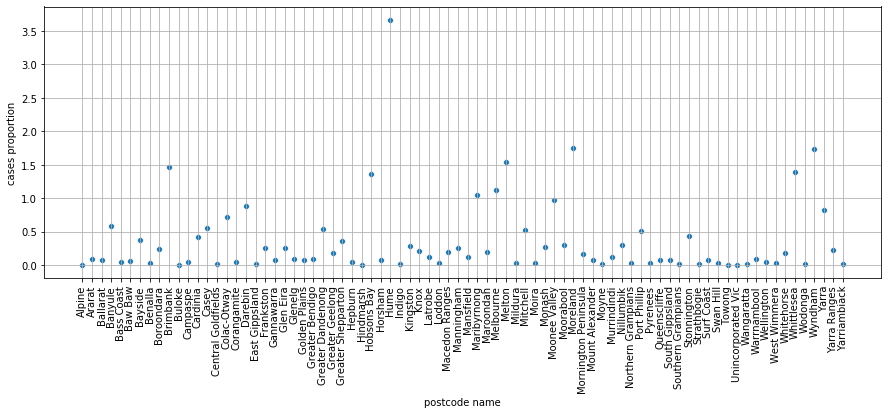

In [45]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
plt.grid(True)
sns.scatterplot(x='postcode name',y='cases proportion',data=x_new)
plt.setp(plt.xticks()[1], rotation=90)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

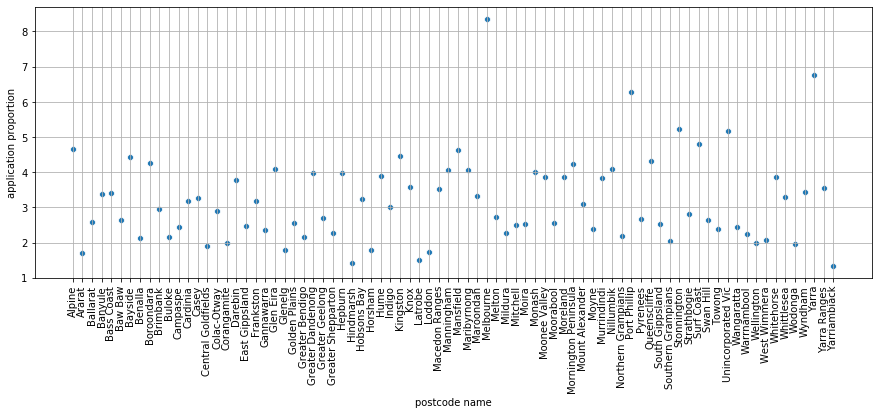

In [26]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
plt.grid(True)
sns.scatterplot(x='postcode name',y='application proportion',data=x_new)
plt.setp(plt.xticks()[1], rotation=90)

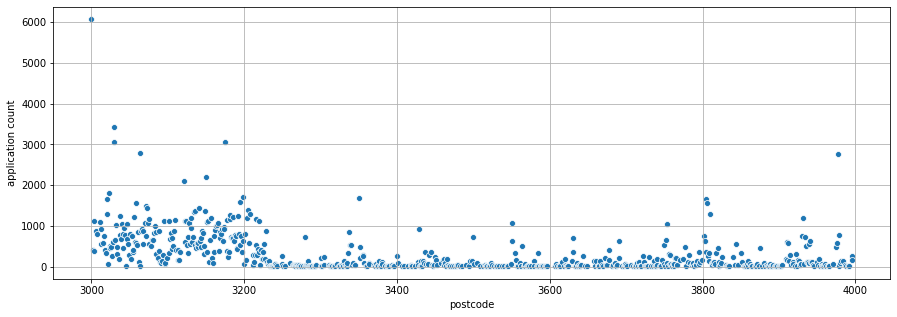

In [46]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
plt.grid(True)
sns.scatterplot(x='postcode',y='application count',data=x);

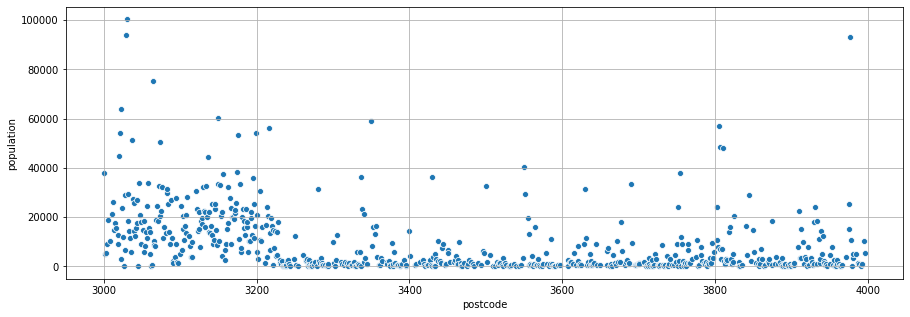

In [18]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
plt.grid(True)
sns.scatterplot(x='postcode',y='population',data=x);

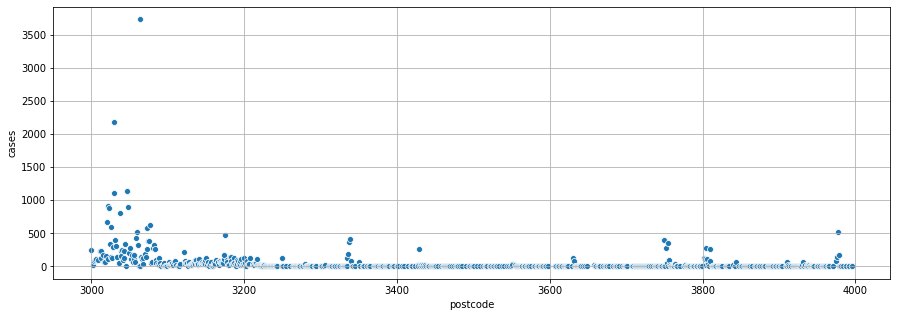

In [47]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
plt.grid(True)
sns.scatterplot(x='postcode',y='cases',data=x);

# Summary Statistics

In [30]:
x_new.describe()

postcode        cases    population  application count       prop  \
count     80.00000    80.000000      80.00000          80.000000  80.000000   
mean   28120.76250   490.850000   73830.55000        2664.965972   0.355341   
std    17041.54753  1086.305038   70147.19233        2834.910128   0.575670   
min     3225.00000     0.000000     114.00000           5.888889   0.000000   
25%    16754.50000     7.000000   15251.75000         393.125000   0.036395   
50%    24650.00000    58.500000   44081.50000        1129.750000   0.110028   
75%    34215.00000   421.000000  120854.75000        5050.500000   0.389598   
max    94302.00000  7323.000000  308105.00000       12078.250000   3.669941   

       cases proportion  application proportion  
count         80.000000               80.000000  
mean           0.355341                3.195315  
std            0.575670                1.230995  
min            0.000000                1.345681  
25%            0.036395                2.337514  
50%            0.110028                2.979952  
75%            0.389598                3.915592  
max            3.669941                8.346002

# New Additions from here

In [67]:
tax_data = pd.read_excel('ts19individual06taxablestatusstateterritorypostcode.xlsx', sheet_name = 'Table 6B')

In [70]:
tax_x = pd.merge(x, tax_data, left_on='postcode', right_on='Postcode')

In [84]:
pd.set_option("display.max_columns", None) 
tax_x

postcode    postcode name  cases  population  application count      prop  \
0       3000        Melbourne    246     37979.0        6063.750000  0.006477   
1       3002        Melbourne     20      4957.0         416.416667  0.004035   
2       3003        Melbourne     83      5516.0         395.750000  0.015047   
3       3004        Melbourne     91      9311.0        1130.250000  0.009773   
4       3006        Melbourne    116     18811.0         867.166667  0.006167   
..       ...              ...    ...         ...                ...       ...   
643     3988  South Gippsland      3      1001.0          26.250000  0.002997   
644     3991       Bass Coast      0       357.0          15.000000  0.000000   
645     3992       Bass Coast      2       966.0          16.250000  0.002070   
646     3995       Bass Coast      4     10171.0         267.583333  0.000393   
647     3996       Bass Coast      4      5541.0         165.916667  0.000722   

    State/ Territory1 Postcode  Number of individuals\nno.  \
0                 VIC     3000                       25566   
1                 VIC     3002                        3810   
2                 VIC     3003                        5039   
3                 VIC     3004                        8596   
4                 VIC     3006                       15055   
..                ...      ...                         ...   
643               VIC     3988                         676   
644               VIC     3991                         247   
645               VIC     3992                         543   
646               VIC     3995                        5598   
647               VIC     3996                        3423   

     Taxable income or loss3\nno.  Taxable income or loss3\n$  \
0                           25022                  1349013218   
1                            3773                   515823134   
2                            4970                   314154240   
3                            8462                   718029059   
4                           14805                  1064208037   
..                            ...                         ...   
643                           669                    30037055   
644                           245                    10556231   
645                           537                    24493854   
646                          5545                   248547224   
647                          3395                   176121248   

     Tax on taxable income\nno.  Tax on taxable income\n$  Medicare levy\nno.  \
0                         18746                 319393019               11222   
1                          3339                 168382636                2990   
2                          4079                  73462298                3040   
3                          7154                 195558883                5823   
4                         12219                 270418404                9224   
..                          ...                       ...                 ...   
643                         534                   5993660                 412   
644                         186                   1894890                 143   
645                         430                   4412191                 342   
646                        4389                  44648426                3495   
647                        2599                  36573772                2136   

     Medicare levy\n$  Medicare levy surcharge\nno.  \
0            20447034                           567   
1             9891450                           151   
2             5352798                           182   
3            12664395                           312   
4            17891030                           545   
..                ...                           ...   
643            545095                            22   
644            169631                             2   
645            415326                

In [92]:
tax_x.corr()

cases  population  \
cases                                               1.000000    0.616985   
population                                          0.616985    1.000000   
application count                                   0.556003    0.870384   
prop                                                0.073912    0.003104   
Number of individuals\nno.                          0.614539    0.991467   
...                                                      ...         ...   
Private health insurance - your Australian Gove...  0.351318    0.871711   
Private health insurance rebate\nno.                0.484584    0.909760   
Private health insurance rebate\n$                  0.404158    0.877428   
Excess private health reduction or refund (reba...  0.329550    0.792659   
Excess private health reduction or refund (reba...  0.235264    0.679014   

                                                    application count  \
cases                                                        0.556003   
population                                                   0.870384   
application count                                            1.000000   
prop                                                         0.043751   
Number of individuals\nno.                                   0.885555   
...                                                               ...   
Private health insurance - your Australian Gove...           0.793124   
Private health insurance rebate\nno.                         0.879738   
Private health insurance rebate\n$                           0.828396   
Excess private health reduction or refund (reba...           0.778890   
Excess private health reduction or refund (reba...           0.700660   

                                                        prop  \
cases                                               0.073912   
population                                          0.003104   
application count                                   0.043751   
prop                                                1.000000   
Number of individuals\nno.                          0.010499   
...                                                      ...   
Private health insurance - your Australian Gove... -0.007415   
Private health insurance rebate\nno.                0.003834   
Private health insurance rebate\n$                 -0.004332   
Excess private health reduction or refund (reba... -0.002570   
Excess private health reduction or refund (reba... -0.007231   

                                                    Number of individuals\nno.  \
cases                                                                 0.614539   
population                                                            0.991467   
application count                                                     0.885555   
prop                                                                  0.010499   
Number of individuals\nno.                                            1.000000   
...                                                                        ...   
Private health insurance - your Australian Gove...                    0.894219   
Private health insurance rebate\nno.                                  0.938560   
Private health insurance rebate\n$                                    0.902728   
Excess private health reduction or refund (reba...                    0.829206   
Excess private health reduction or refund (reba...                    0.719101   

                                                    Taxable income or loss3\nno.  \
cases                                                                   0.613000   
population                                                              0.991507   
application count                                                       0.884956   
prop                                                                    0.010391   
Number of individuals\nno.                                              0.999991   
...    

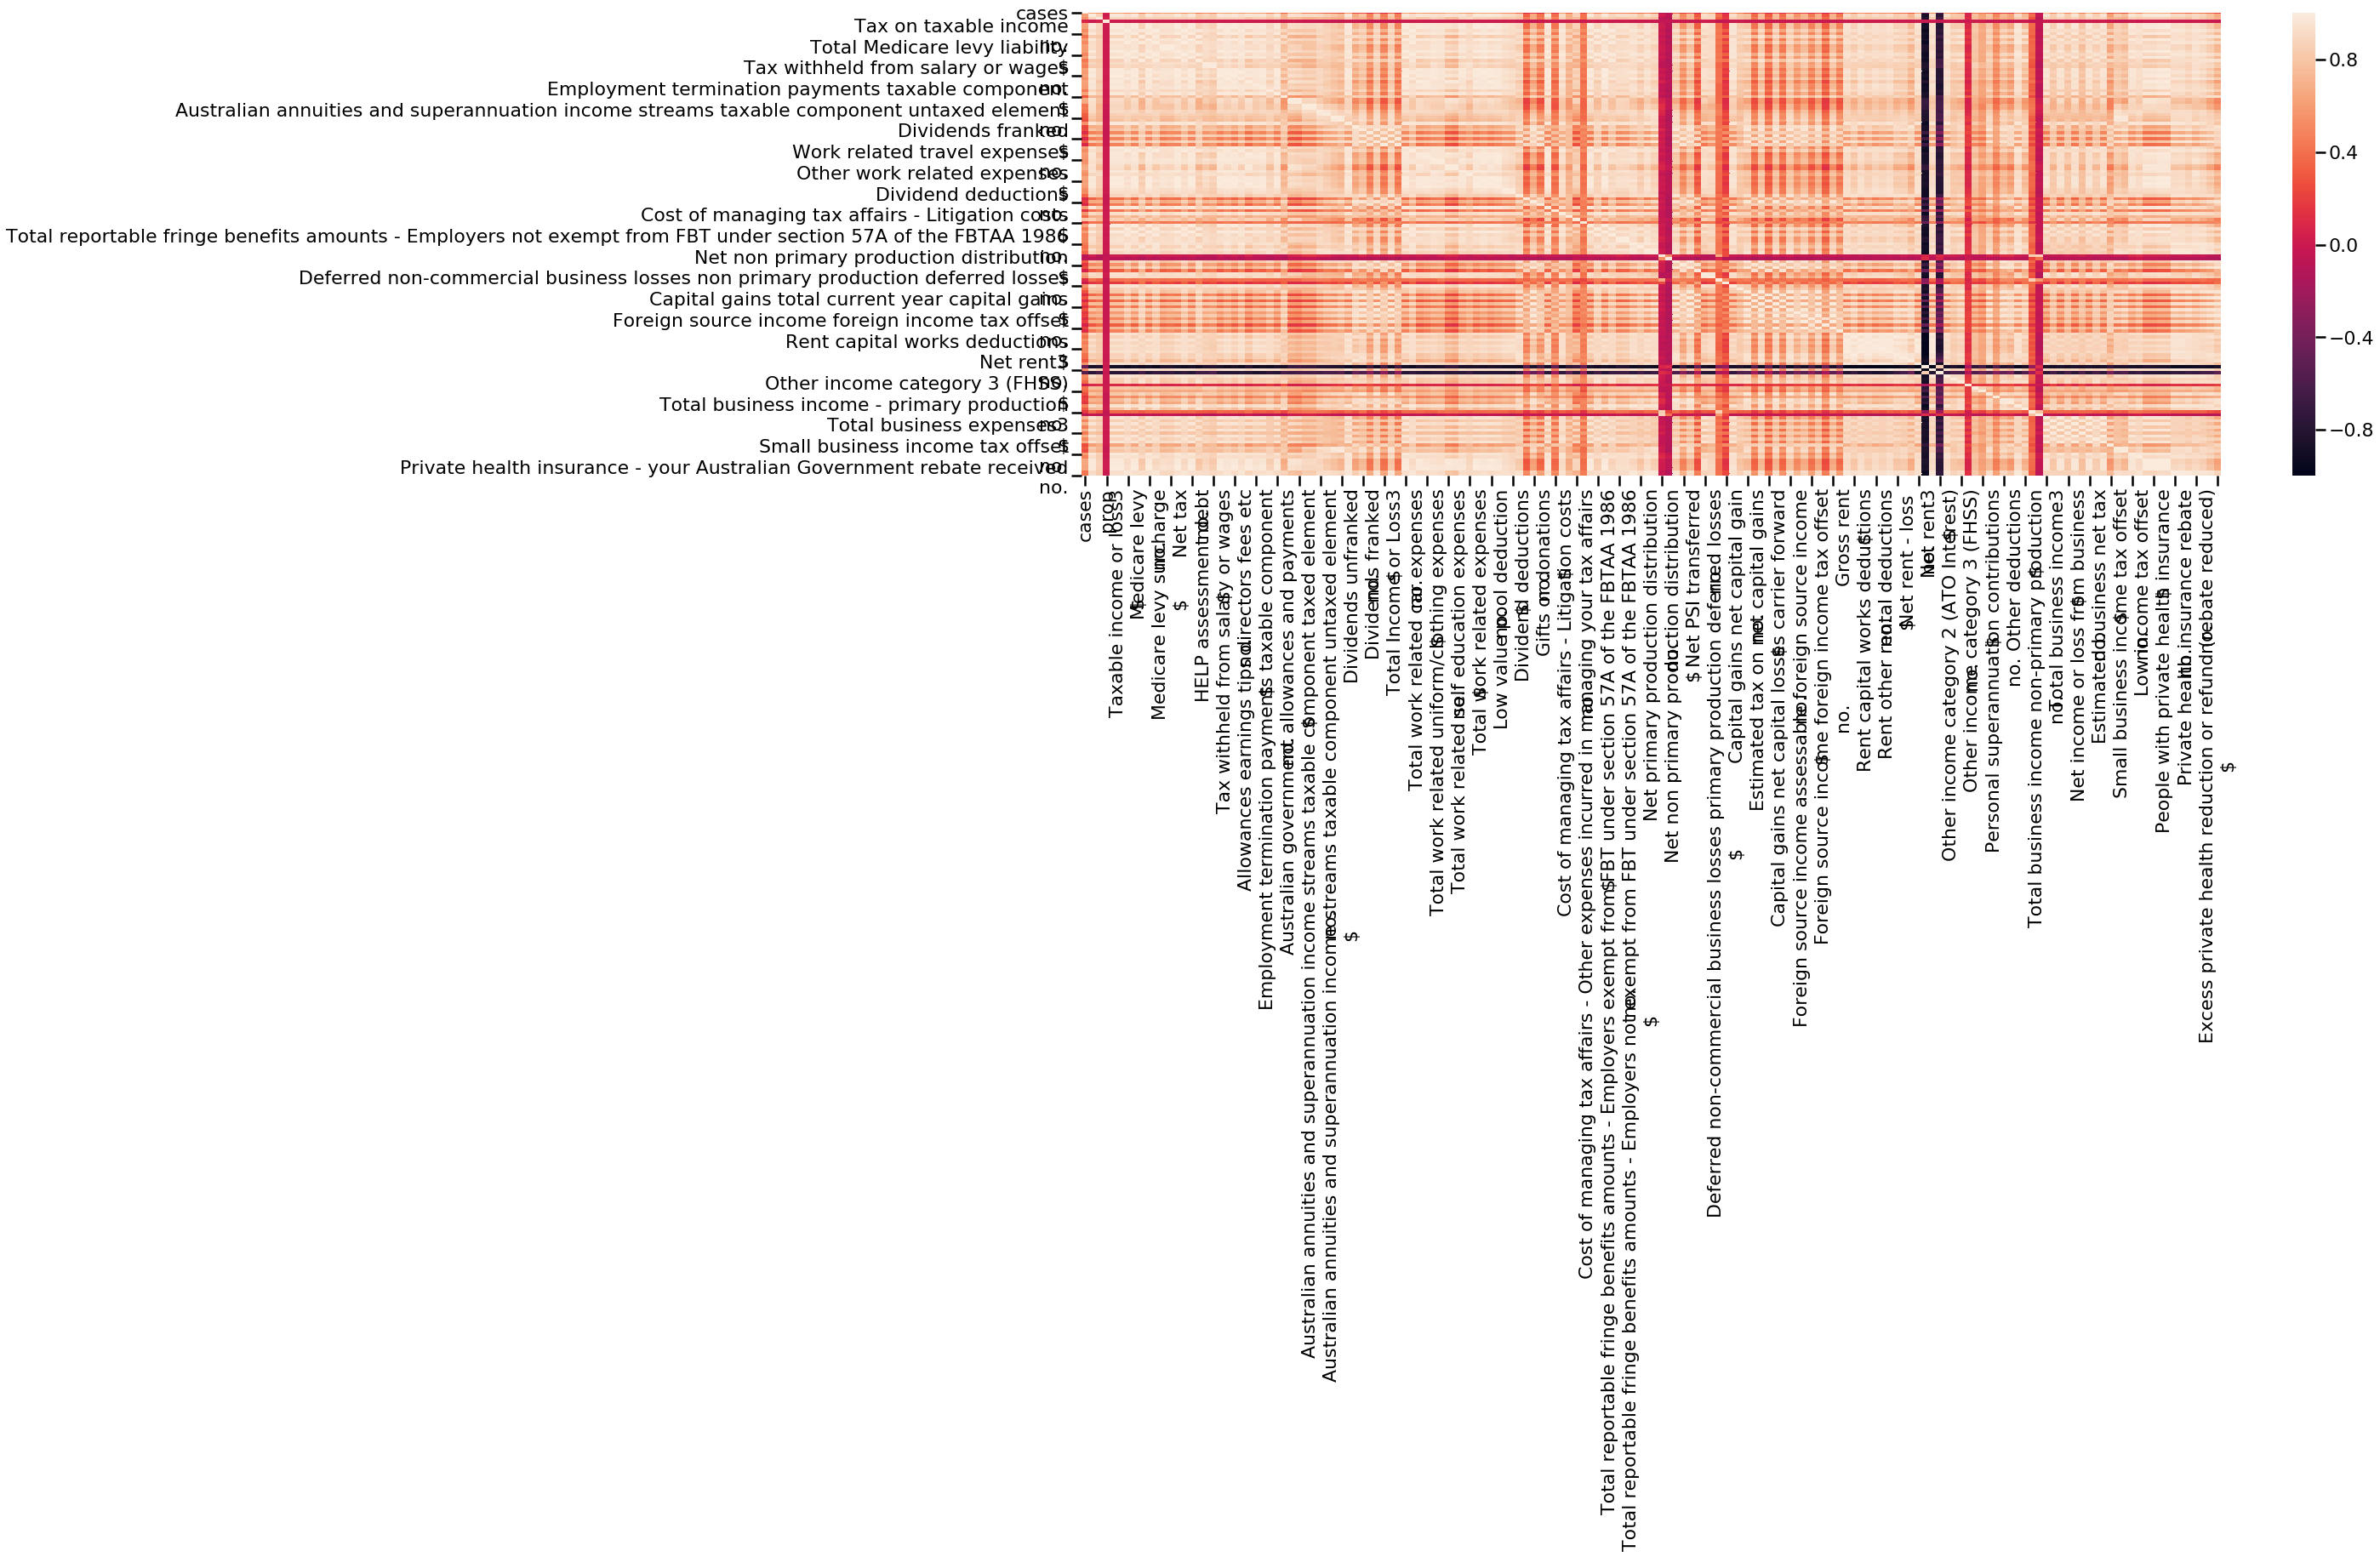

In [96]:
plt.figure(figsize=(30,10))
sns.heatmap(tax_x.corr())

In [97]:
# imports
import plotly.express as px 
import pandas as pd 
import numpy as np 

# plotly 
fig = px.line(tax_x, x='postcode', y='Number of individuals\nno.')

fig.update_layout(legend=dict(
    yanchor="top",
    y=1.12,
    xanchor="right",
    x=1.00
))

# Show plot 
fig.show()

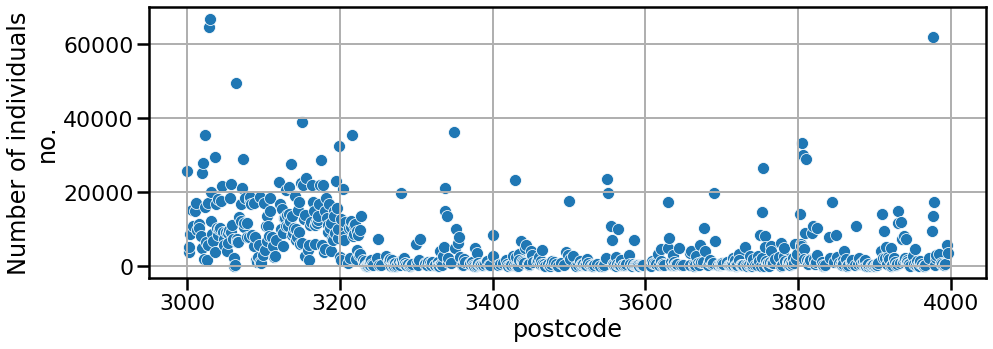

In [82]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
plt.grid(True)
sns.scatterplot(x='postcode',y='Number of individuals\nno.',data=tax_x);

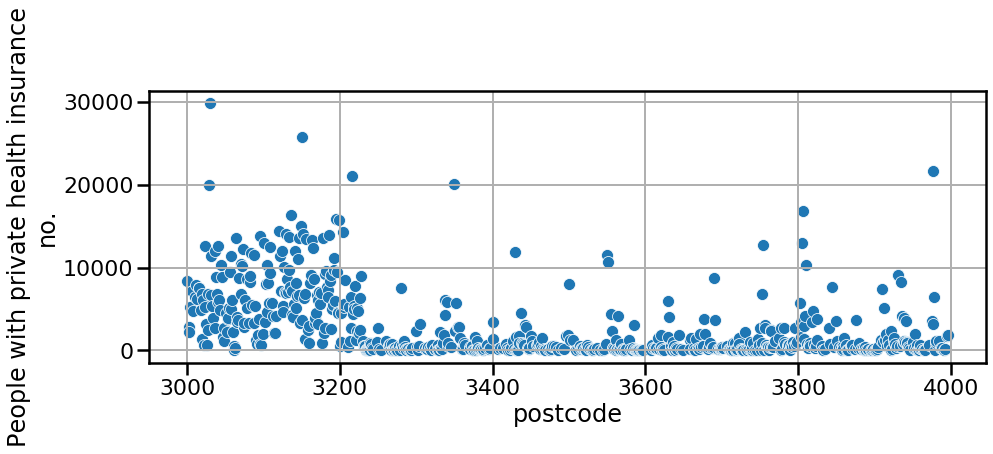

In [81]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
plt.grid(True)
sns.scatterplot(x='postcode',y='People with private health insurance\nno.',data=tax_x);

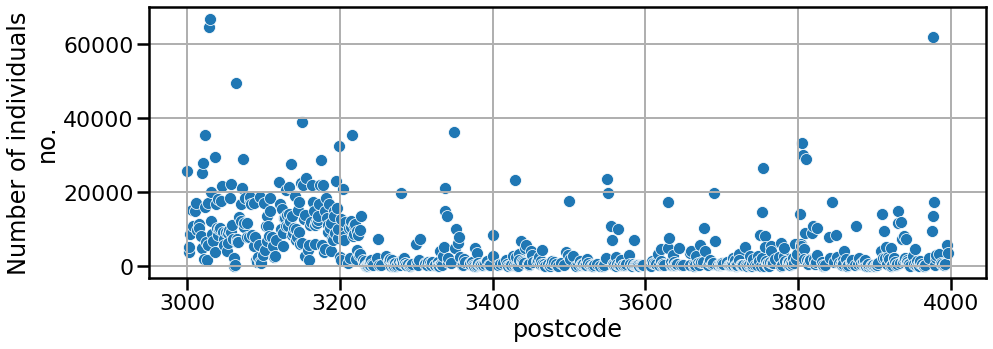

In [75]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
plt.grid(True)
sns.scatterplot(x='postcode',y='Number of individuals\nno.',data=tax_x);

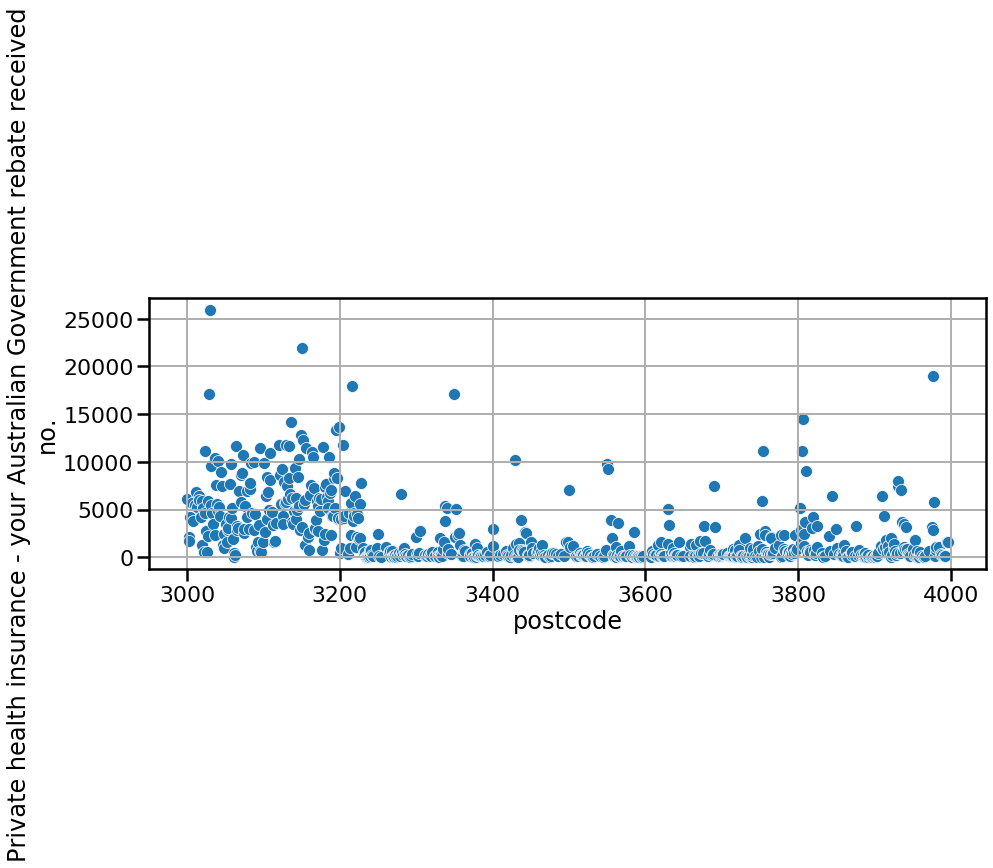

In [77]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
plt.grid(True)
sns.scatterplot(x='postcode',y='Private health insurance - your Australian Government rebate received\nno.',data=tax_x);

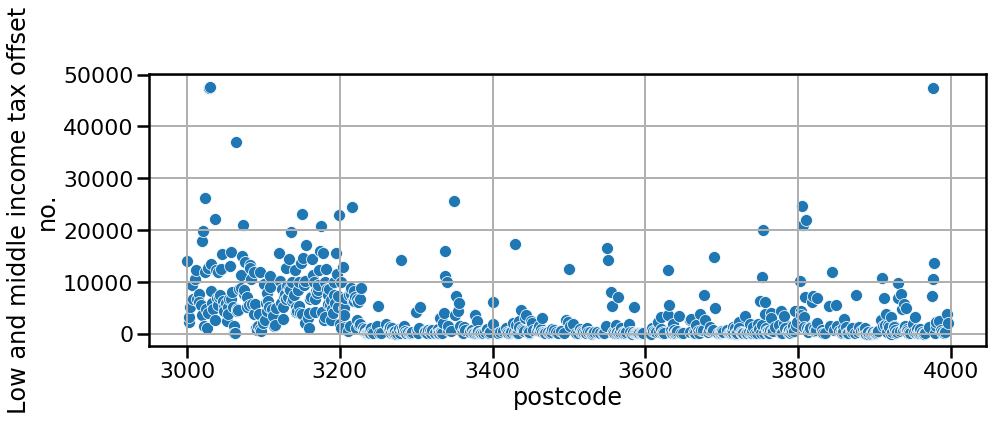

In [79]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,5))
plt.grid(True)
sns.scatterplot(x='postcode',y='Low and middle income tax offset\nno.',data=tax_x);